# Read Data

In [1]:
# Import Libraries and Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("source data/twitter_human_bots_dataset.csv", index_col=0)
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


# Data Cleaning

## Handling missing values

description, lang, location, profile_image_url and profile_background_image_url have missing values.

### Missing descriptions

As there are many bot accounts with missing description, this is a significant value, we would add a check for missing descriptions.

In [3]:
df.loc[df['description'].isnull(), 'account_type'].value_counts()
df['is_description_na'] = df['description'].isna().astype(int)
df.loc[df['description'].isnull(), 'description'] = ''

### Missing lang

As there are many bot accounts with missing lang, this is a significant value, we would add a check for missing langs.

In [4]:
df.loc[df['lang'].isnull(), 'account_type'].value_counts()
df['is_lang_na'] = df['lang'].isna().astype(int)
df.loc[df['lang'].isnull(), 'lang'] = ''

### Missing location

We set the missing locations to 'unknown' as that is already a value in the feature.

In [5]:
df.loc[df['location'].isnull(), 'account_type'].value_counts()
df.loc[df['location'].isnull(), 'location'] = 'unknown'

### Missing profile_background_image_url

We set the missing profile_background_image_url to the default url.

In [6]:
df.loc[df['profile_background_image_url'].isnull(), 'account_type'].value_counts()
default_background = df['profile_background_image_url'].mode()[0]
df.loc[df['profile_background_image_url'].isnull(), 'profile_background_image_url'] = default_background

### Missing profile_image_url

We set the missing profile_image_url to the default url.

In [7]:
df.loc[df['profile_image_url'].isnull(), 'account_type'].value_counts()
default_image = df['profile_image_url'].mode()[0]
df.loc[df['profile_image_url'].isnull(), 'profile_image_url'] = default_image

In [8]:
print(df.isnull().sum())    

created_at                      0
default_profile                 0
default_profile_image           0
description                     0
favourites_count                0
followers_count                 0
friends_count                   0
geo_enabled                     0
id                              0
lang                            0
location                        0
profile_background_image_url    0
profile_image_url               0
screen_name                     0
statuses_count                  0
verified                        0
average_tweets_per_day          0
account_age_days                0
account_type                    0
is_description_na               0
is_lang_na                      0
dtype: int64


# Feature Engineering
* Feature Creation
* Feature Reduction (using Weight of Evidence(woe) check for feature importance, Correlation)
* Run feature selection using tree base algo (random forest or smth)

## Encoding categorical variables

### Encoding boolean features into 0 and 1s

In [8]:
df['account_type_map'] = df['account_type'].map({'bot': 1, 'human': 0})

df['default_profile'] = df['default_profile'].astype(int)
df['default_profile_image'] = df['default_profile_image'].astype(int)
df['verified'] = df['verified'].astype(int)
df['geo_enabled'] = df['geo_enabled'].astype(int)


### Encoding common values for lang and location

In [9]:
df['is_lang_en'] = df['lang'].map({'en': 1}).fillna(0)
print(df['is_lang_en'].value_counts())  

is_lang_en
1.0    21450
0.0    15988
Name: count, dtype: int64


### Encoding unknown values for location

In [10]:
df['is_location_unknown'] = df['location'].map({'unknown': 1}).fillna(0)
print(df['is_location_unknown'].value_counts())

is_location_unknown
0.0    24411
1.0    13027
Name: count, dtype: int64


## Transformed Features to Consider

In addition to the original features, several transformed features have been engineered to enrich the dataset and provide more nuanced insights into user behavior. These features capture various aspects of user profiles, activity, and engagement.

### Newly Created Features

1. **Sentiment Analysis of Description**: The sentiment score of the user's profile description (e.g., positive, negative, neutral) can reveal underlying attitudes or personality traits.
2. **Number of Mentions in Description**: Counts the number of mentions in the description, potentially indicating networked behavior or connections.
3. **Influencer Type**: Classifies users into categories (e.g., Nano, Micro, Macro) based on their follower count.
4. **Length of Description**: Measures the character length of the description, which may indicate user effort or interest level in maintaining a profile.
5. **Favorite Activity Level**: Reflects each user’s engagement with specific activities (e.g., likes, retweets) as a proxy for activity intensity.
6. **Ratio of Followers Count to Friends Count**: Captures the balance of followers versus following, indicating a user's influence or engagement focus.
7. **Ratio of Followers Count to Tweets per Day**: Analyzes the relationship between a user’s followers and tweet frequency, indicating follower acquisition per tweet.
8. **Ratio of Friends Count to Tweets per Day**: Examines the friends-to-tweets ratio, highlighting how user interactions compare to their tweet activity.
9. **Ratio of Tweets to Account Age**: Measures tweet frequency over the lifetime of the account, indicating activity level consistency.
10. **Account Creation Time**: Records the hour of account creation, adjusted for the user’s time zone based on their location, with a particular interest in accounts created past midnight.
11. **Standard Deviation of Avg Tweets from Avg Tweets of Bots**: Measures each user’s deviation in tweet frequency from the average tweet frequency of known bots.

   - **Calculate after Train-Test Split**: To avoid data leakage, calculate the standard deviation of average tweets relative to the average bot tweets only after splitting the data.
   - **Use Training Data Average for Consistency**: Calculate the bot average tweet frequency on the training set, then use this average to compute deviations for both the training and test sets, ensuring a consistent benchmark.

### Summary of Features

- **Original Features**: 18 features from the initial dataset.
- **Transformed Features**: 11 additional features, created to provide deeper insights and facilitate more effective modeling.

**Total Feature Count**: 29 features (18 original + 11 created)

These additional features enrich the dataset by capturing essential behavioral, temporal, and engagement-based patterns, enhancing the depth of analysis and model accuracy potential.


In [11]:
df['created_at'] = pd.to_datetime(df['created_at'])

current_time = datetime.now()
df['account_age_days'] = (current_time - df['created_at']).dt.days

df['creation_hour'] = df['created_at'].dt.hour

df['creation_day_of_week'] = df['created_at'].dt.dayofweek

df['creation_month'] = df['created_at'].dt.month

df['creation_year'] = df['created_at'].dt.year

df['is_weekend'] = df['created_at'].dt.dayofweek >= 5

df['creation_quarter'] = df['created_at'].dt.quarter

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['creation_hour'].apply(part_of_day)

df['creation_week_of_year'] = df['created_at'].dt.isocalendar().week

df['is_beginning_of_month'] = df['created_at'].dt.day <= 5
df['is_end_of_month'] = df['created_at'].dt.day >= 26

tmp_lst = ['account_age_days','creation_hour','creation_day_of_week','creation_month','creation_year','creation_quarter']
tmp_lst_cat = ['is_weekend','part_of_day','is_beginning_of_month','is_end_of_month']
df[tmp_lst].describe()
df[tmp_lst_cat].value_counts()


is_weekend  part_of_day  is_beginning_of_month  is_end_of_month
False       Night        False                  False              7102
            Afternoon    False                  False              4030
            Evening      False                  False              3970
            Morning      False                  False              3311
True        Night        False                  False              2255
False       Night        False                  True               1830
                         True                   False              1707
True        Afternoon    False                  False              1282
            Evening      False                  False              1270
            Morning      False                  False              1205
False       Evening      False                  True               1082
                         True                   False              1058
            Afternoon    False                  True               1032


#### Length of Description Feature

In [12]:
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
print(df['description_length'].describe())
print(df['description_length'].isna().sum())

count    37438.000000
mean        67.017202
std         55.217549
min          0.000000
25%         14.000000
50%         58.000000
75%        118.000000
max        191.000000
Name: description_length, dtype: float64
0


### Categorizing Influencers by Follower Count

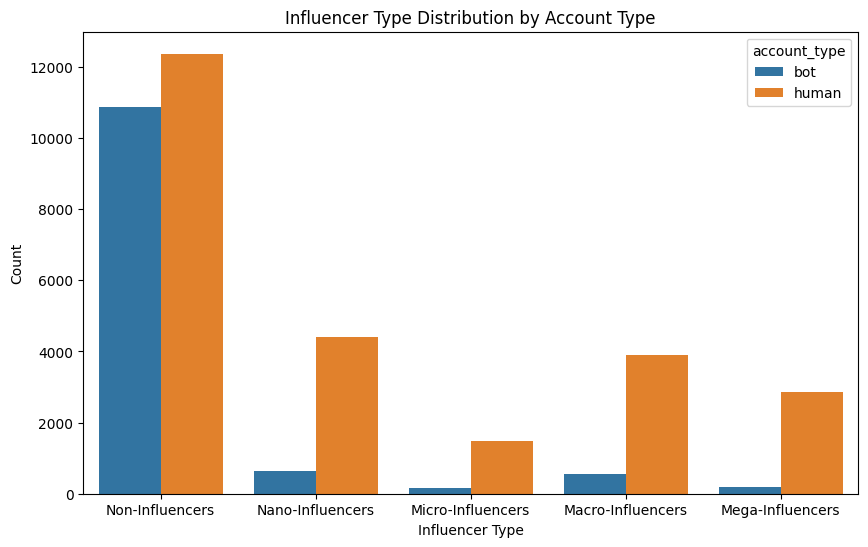

In [13]:
bins = [0, 1000, 10000, 40000, 1000000, float('inf')]
labels = ['Non-Influencers','Nano-Influencers', 'Micro-Influencers', 'Macro-Influencers', 'Mega-Influencers']

# Create the `influencer_type` column based on the bins and labels
df['influencer_type'] = pd.cut(df['followers_count'], bins=bins, labels=labels, right=False)

# Set plot size
plt.figure(figsize=(10, 6))

# Create a count plot to show influencer type distribution by account type
sns.countplot(data=df, x='influencer_type', hue='account_type')

# Add title and labels
plt.title('Influencer Type Distribution by Account Type')
plt.xlabel('Influencer Type')
plt.ylabel('Count')

# Show plot
plt.show()

### Categorizing Users by Favorite Activity Level

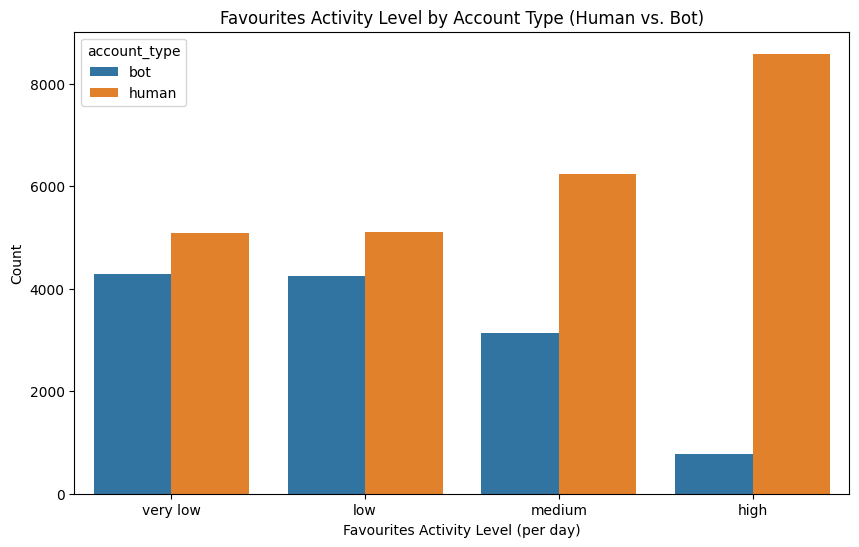

In [14]:
# Calculate favourites per day
df['favourites_per_day'] = df['favourites_count'] / df['account_age_days']

# Quantile bucketing for favourites_per_day
df['favourites_activity'] = pd.qcut(df['favourites_per_day'], q=4, labels=['very low', 'low', 'medium', 'high'])

# Visualize the distribution of favourites_activity by account_type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='favourites_activity', hue='account_type')

# Add title and labels
plt.title('Favourites Activity Level by Account Type (Human vs. Bot)')
plt.xlabel('Favourites Activity Level (per day)')
plt.ylabel('Count')

# Show plot
plt.show()

### Ratio of Followers to Friends

In [15]:
df['followers_to_friends_ratio'] = df.apply(
    lambda row: row['followers_count'] / row['friends_count'] if row['friends_count'] != 0 else np.nan, axis=1
)

ratio_95th_percentile = df['followers_to_friends_ratio'].quantile(0.95)
# Cap the ratio at the 95th percentile
df['followers_to_friends_ratio'] = df['followers_to_friends_ratio'].apply(
    lambda x: min(x, ratio_95th_percentile) if not np.isnan(x) else x
)


df['followers_to_friends_ratio'].describe()

count    31028.000000
mean       628.178169
std       1812.745244
min          0.000000
25%          0.420908
50%          1.153846
75%         20.509693
max       7428.411956
Name: followers_to_friends_ratio, dtype: float64

### Ratio of Followers_count to tweets per day

In [16]:
# Calculate the followers_to_tweets_per_day_ratio
df['followers_to_tweets_per_day_ratio'] = df.apply(
    lambda row: row['followers_count'] / row['average_tweets_per_day'] if row['average_tweets_per_day'] != 0 else np.nan, axis=1
)

ratio_95th_percentile = df['followers_to_tweets_per_day_ratio'].quantile(0.95)

# Cap the ratio at the 95th percentile
df['followers_to_tweets_per_day_ratio'] = df['followers_to_tweets_per_day_ratio'].apply(
    lambda x: min(x, ratio_95th_percentile) if not np.isnan(x) else x
)

# Display the descriptive statistics after capping
print(df['followers_to_tweets_per_day_ratio'].describe())

count     37366.000000
mean      68549.469064
std      205257.661473
min           0.000000
25%          46.451320
50%         216.117817
75%        2747.764703
max      852077.436863
Name: followers_to_tweets_per_day_ratio, dtype: float64


### Ratio of friends to tweets per day

In [17]:
df['friends_to_tweets_per_day_ratio'] = df.apply(
    lambda row: row['friends_count'] / row['average_tweets_per_day'] if row['average_tweets_per_day'] != 0 else np.nan, axis=1
)

friends_tweets_ratio_95th_percentile = df['friends_to_tweets_per_day_ratio'].quantile(0.95)

df['friends_to_tweets_per_day_ratio'] = df['friends_to_tweets_per_day_ratio'].apply(
    lambda x: min(x, friends_tweets_ratio_95th_percentile) if not np.isnan(x) else x
)

# Display the descriptive statistics after capping
print(df['friends_to_tweets_per_day_ratio'].describe())

count    37366.000000
mean       528.971781
std        990.552554
min          0.000000
25%         19.169213
50%        124.785093
75%        462.979888
max       3999.126383
Name: friends_to_tweets_per_day_ratio, dtype: float64


### Resolving NA in created features

In [18]:
# Count null values in each column
null_followers_to_friends_ratio = df['followers_to_friends_ratio'].isnull().sum()
null_followers_to_tweets_per_day_ratio = df['followers_to_tweets_per_day_ratio'].isnull().sum()
null_friends_to_tweets_per_day_ratio = df['friends_to_tweets_per_day_ratio'].isnull().sum()

# Display the counts
print("Null values in followers_to_friends_ratio:", null_followers_to_friends_ratio)
print("Null values in followers_to_tweets_per_day_ratio:", null_followers_to_tweets_per_day_ratio)
print("Null values in friends_to_tweets_per_day_ratio:", null_friends_to_tweets_per_day_ratio)


Null values in followers_to_friends_ratio: 6410
Null values in followers_to_tweets_per_day_ratio: 72
Null values in friends_to_tweets_per_day_ratio: 72


In [19]:
df['followers_to_friends_ratio'].fillna(0, inplace=True)
df['followers_to_tweets_per_day_ratio'].fillna(0, inplace=True)
df['friends_to_tweets_per_day_ratio'].fillna(0, inplace=True)

### Extracting mentions count

In [20]:
def extract_mentions(description):
    mentions = re.findall(r'@\w+', str(description))
    return mentions

# Apply the function to the description column to create a new column with the mentions
df['mentions'] = df['description'].apply(extract_mentions)

# Feature: Count of mentions
df['mention_count'] = df['mentions'].apply(len)

# Display the dataframe with the new columns
print(df[['description', 'mentions', 'mention_count' ]].head())


                                         description  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...   
1  Photographing the American West since 1980. I ...   
2  Scruffy looking nerf herder and @twitch broadc...   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...   
4               Loan coach at @mancity & Aspiring DJ   

                     mentions  mention_count  
0  [@xaiax, @MakingInvisible]              2  
1                          []              0  
2           [@twitch, @gmail]              2  
3                          []              0  
4                  [@mancity]              1  


### Log numerical columns
Log columns to handle large disparity in values.

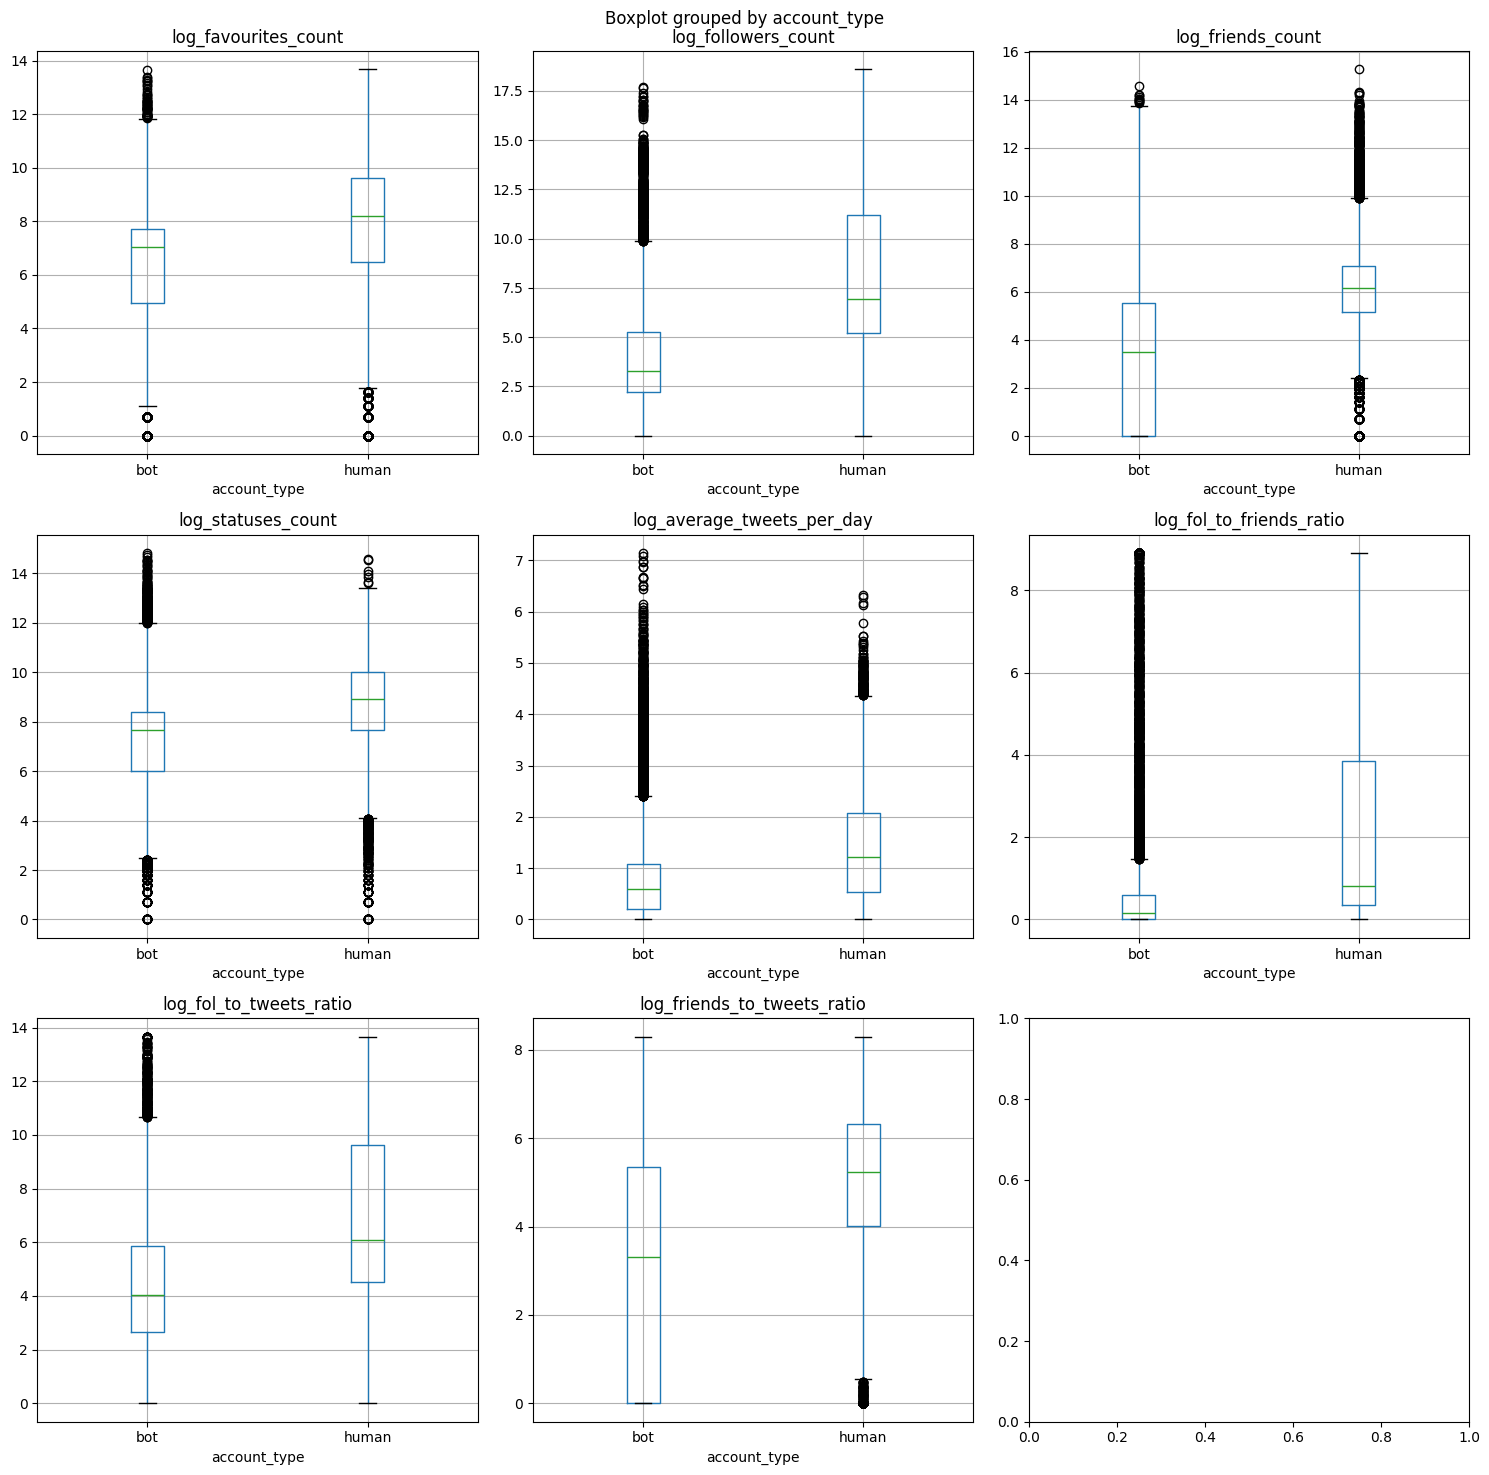

In [21]:
# Log transformation of columns
df['log_favourites_count'] = np.log1p(df['favourites_count'])
df['log_followers_count'] = np.log1p(df['followers_count'])
df['log_friends_count'] = np.log1p(df['friends_count'])
df['log_statuses_count'] = np.log1p(df['statuses_count'])
df['log_average_tweets_per_day'] = np.log1p(df['average_tweets_per_day'])
df['log_fol_to_friends_ratio'] = np.log1p(df['followers_to_friends_ratio'])
df['log_fol_to_tweets_ratio'] = np.log1p(df['followers_to_tweets_per_day_ratio'])
df['log_friends_to_tweets_ratio'] = np.log1p(df['friends_to_tweets_per_day_ratio'])

# Plot boxplot
log_columns = ['log_favourites_count', 'log_followers_count', 'log_friends_count', 'log_statuses_count', 'log_average_tweets_per_day',
               'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio', 'log_friends_to_tweets_ratio']

# Create a grid of boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Iterate over the columns and plot the boxplot in the corresponding axis
for i, column in enumerate(log_columns):
    ax = axes[i // 3, i % 3]
    df.boxplot(column=column, ax=ax, by='account_type')
    ax.set_title(column)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Encoding Features

In [22]:
# Encoding Categorical Features
df['account_type'] = df['account_type'].map({'human': 0, 'bot': 1})

encode_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'lang', 'location', 'verified',
               'creation_year', 'is_weekend', 'is_beginning_of_month', 'is_end_of_month', 'part_of_day','influencer_type',
               'favourites_activity']

label_encoder = LabelEncoder()
for col in encode_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs if any




## Feature Analysis
Determining correlation with the target variable `account_type_map`.

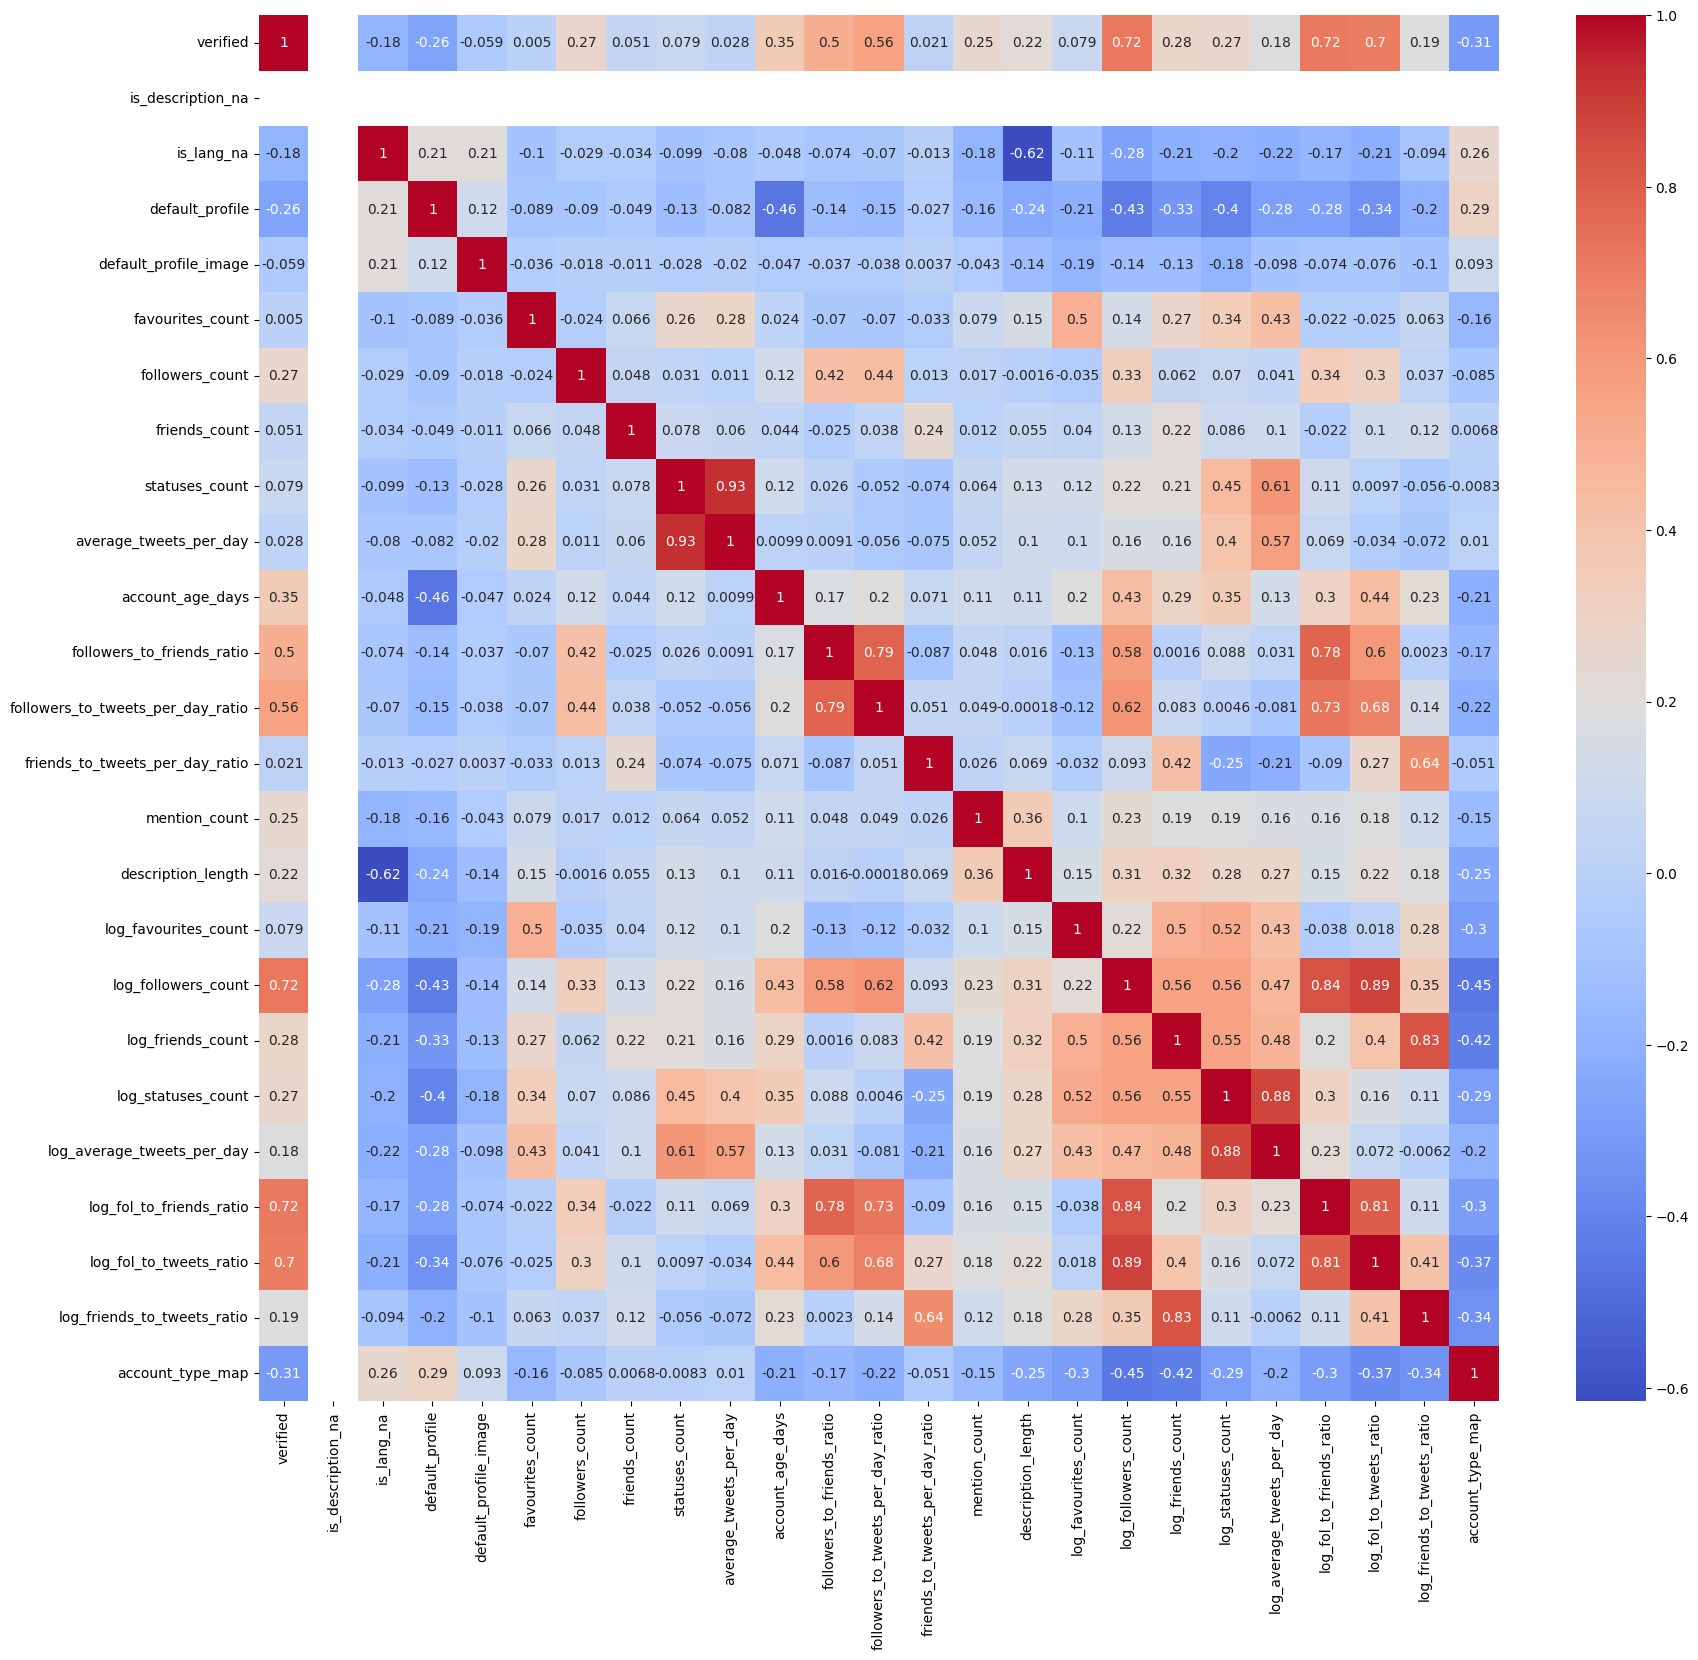

In [23]:

# Select numerical columns
numerical_columns = ['verified', 'is_description_na', 'is_lang_na', 'default_profile', 
                     'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
                     'statuses_count', 'average_tweets_per_day', 'account_age_days', 
                     'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'friends_to_tweets_per_day_ratio',
                     'mention_count', 'description_length', 
                     'log_favourites_count', 'log_followers_count', 'log_friends_count', 'log_statuses_count', 'log_average_tweets_per_day',
                     'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio', 'log_friends_to_tweets_ratio',
                     'account_type_map']

# Calculate correlation matrix
correlation_matrix = df[numerical_columns].corr()
# Set the figure size
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

# Since statuses_count and average_tweets_per_day are highly correlated, we have to drop one of them
# As average_tweets_per_day has a higher correlation with the target variable, we will drop statuses_count

## Weight of Evidence

<strong>How WOE works:</strong>

Run the features you want to conduct weight of evidence on. For example, I put the features in temp_list and then created a dataframe containing only those features in df_tmp.

* Step 1: Replace temp_list with your features
* Step 2: Run code chunk below
* Step 3: Look at the WOE score for each bin of each feature to interpret WOE results

How to Interpret WOE scores
Negative or Positive Values indicate the direction of the feature while the magnitude indicate the strength of the feature.
E.g For the feature "statuses_count", if the woe score for one of its bin is 0.5 it indicates that for that bin, the feature "statuses_count" identifies many bots.
Conversely if the woe score for one of its bin is -0.7, it means that the feature is not good a predicting bots.

Also do look at the IV scores to determine the features contribution. Generally an IV of >0.02 indicates weak predictive power while >0.5 indicates strong predictive power.

In [23]:
temp_lst = ['favourites_count', 'followers_count','account_type','mention_count']

#Transforming Bot/Human to 1s and 0s
df['account_type'] = df['account_type'].replace({'bot': 1, 'human': 0})

y = df['account_type']  
X = df.drop(columns=['account_type'])  

df_tmp = df[temp_lst]
# Conduct the binning process using woebin
bins = sc.woebin(df_tmp, y='account_type', bins = 5)

# Display the binning information (optional to view WoE values per variable)
for key in bins.keys():
    print(f"Binning for {key}:")
    print(bins[key])


[INFO] creating woe binning ...
Binning for favourites_count:
           variable              bin  count  count_distr   good    bad  \
0  favourites_count    [-inf,3000.0)  22524     0.601635  11704  10820   
1  favourites_count  [3000.0,5000.0)   2707     0.072306   2167    540   
2  favourites_count     [5000.0,inf)  12207     0.326059  11142   1065   

    badprob       woe    bin_iv  total_iv  breaks  is_special_values  
0  0.480376  0.621151  0.250267  0.872914  3000.0              False  
1  0.199483 -0.689845  0.029783  0.872914  5000.0              False  
2  0.087245 -1.648062  0.592864  0.872914     inf              False  
Binning for followers_count:
          variable             bin  count  count_distr   good    bad  \
0  followers_count    [-inf,500.0)  20173     0.538838   9881  10292   
1  followers_count  [500.0,1500.0)   4511     0.120493   3685    826   
2  followers_count    [1500.0,inf)  12754     0.340670  11447   1307   

    badprob       woe    bin_iv  total_

# Output cleaned data

In [50]:
df.columns

Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_background_image_url',
       'profile_image_url', 'screen_name', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type',
       'is_description_na', 'is_lang_na', 'account_type_map', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio',
       'friends_to_tweets_per_day_ratio', 'mentions', 'mention_count',
       'log_favourites_count', 'log_followers_count', 'log_friends_count',
 

In [24]:
# Define Feature Columns and Target
id_col = ['id']
labels = ['account_type']

predictive_cols = ['default_profile', 'default_profile_image',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
        'lang', 'location', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days',
       'is_description_na', 'is_lang_na', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio',
       'friends_to_tweets_per_day_ratio', 'mention_count',
       'log_favourites_count', 'log_followers_count', 'log_friends_count',
       'log_statuses_count', 'log_average_tweets_per_day',
       'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio',
       'log_friends_to_tweets_ratio','account_type', 'description', 'screen_name']

non_predictive_cols = ['description','profile_background_image_url','profile_image_url','screen_name','mentions']

target = ['account_type']

id = ['id']

# Set cutoff date for training/validation split
cutoff_date = pd.to_datetime('2017-01-01')
df['date'] = pd.to_datetime(df['created_at'])

# Define columns to keep
id_cols = ['id']
target_cols = ['account_type']
# Assuming predictive_cols is already defined
columns_to_keep = id_cols + predictive_cols

# Filter columns before splitting
df_filtered = df[columns_to_keep + ['date']]

# Split data based on cutoff date
oot = df_filtered[df_filtered['date'] >= cutoff_date].set_index('id')
df_model = df_filtered[df_filtered['date'] < cutoff_date].set_index('id')

# Drop date column as it's no longer needed
oot = oot.drop('date', axis=1)
df_model = df_model.drop('date', axis=1)

# Train, Test, Validation Splits
RANDOM_SEED = 2024
train, test = train_test_split(df_model, test_size=0.2, random_state=RANDOM_SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

# Add 'X_fold' columns for each split
train['X_fold'] = 'train'
test['X_fold'] = 'test'
valid['X_fold'] = 'valid'
oot['X_fold'] = 'oot'

# Combine all datasets for modeling
mds = pd.concat([train, test, valid, oot]).copy(deep=True)
mds = mds.reset_index()
#mds.fillna(0, inplace = True)

### Deviation From Humans

In [25]:
humans_mean = mds[(mds['account_type'] == 0) & (mds['X_fold'] == 'train')]['average_tweets_per_day'].mean()
humans_std = mds[(mds['account_type'] == 0) & (mds['X_fold'] == 'train')]['average_tweets_per_day'].std()
mds['deviation_from_humans'] = mds['average_tweets_per_day'].apply(
     lambda x: (x - humans_mean) / humans_std
 )
mds['deviation_from_humans'].describe()


count    37438.000000
mean         0.014523
std          1.719083
min         -0.467466
25%         -0.432847
50%         -0.363398
75%         -0.080849
max         88.287654
Name: deviation_from_humans, dtype: float64

In [30]:
df_sentiment = pd.read_csv('cleaned data/df_sentiment.csv')
merged_df = pd.merge(mds, df_sentiment, on='screen_name', how='inner')
merged_df.to_csv('cleaned data/cleaned_data_split.csv', index =False)

In [51]:
df.to_csv('cleaned data/cleaned_data.csv', index=False)